I despise clocks

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import gc
import random
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import xception
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

In [2]:
pd.options.display.max_rows = 100

In [3]:
image_dir = 'images'
labels_dir = 'label.csv'

In [4]:
new_size = (299, 299)

# loop through each image in the directory
for filename in os.listdir(image_dir):
    # read the image
    img = cv2.imread(os.path.join(image_dir, filename))
    # resize the image
    resized_img = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)
    # save the resized image
    cv2.imwrite(os.path.join(image_dir, filename), resized_img)

In [5]:
labels = pd.read_csv(labels_dir)
labels.describe()

,hour,minute
count,50000.000000,50000.000000
mean,5.522940,29.531240
std,3.459953,17.210759
min,0.000000,0.000000
25%,3.000000,15.000000
50%,6.000000,30.000000
75%,9.000000,44.000000
max,11.000000,59.000000


In [6]:
labels.hour.value_counts(normalize=True)

8     0.08580
11    0.08546
6     0.08462
10    0.08452
1     0.08428
2     0.08290
7     0.08286
3     0.08248
0     0.08246
4     0.08180
5     0.08164
9     0.08118
Name: hour, dtype: float64

In [7]:
labels.minute.value_counts(normalize=True)

37    0.01804
19    0.01790
39    0.01778
32    0.01776
44    0.01774
13    0.01744
45    0.01744
28    0.01736
17    0.01734
47    0.01732
4     0.01724
21    0.01718
22    0.01716
26    0.01710
16    0.01708
46    0.01706
34    0.01704
36    0.01702
23    0.01700
55    0.01692
50    0.01690
49    0.01688
27    0.01686
51    0.01684
33    0.01682
11    0.01680
7     0.01680
31    0.01674
42    0.01672
38    0.01670
41    0.01670
24    0.01662
18    0.01652
15    0.01652
48    0.01650
57    0.01646
6     0.01644
12    0.01644
20    0.01642
8     0.01642
1     0.01640
56    0.01632
3     0.01630
59    0.01630
29    0.01628
0     0.01626
9     0.01624
52    0.01614
40    0.01610
53    0.01602
54    0.01600
10    0.01598
35    0.01586
14    0.01580
5     0.01576
25    0.01574
30    0.01574
2     0.01566
58    0.01556
43    0.01552
Name: minute, dtype: float64

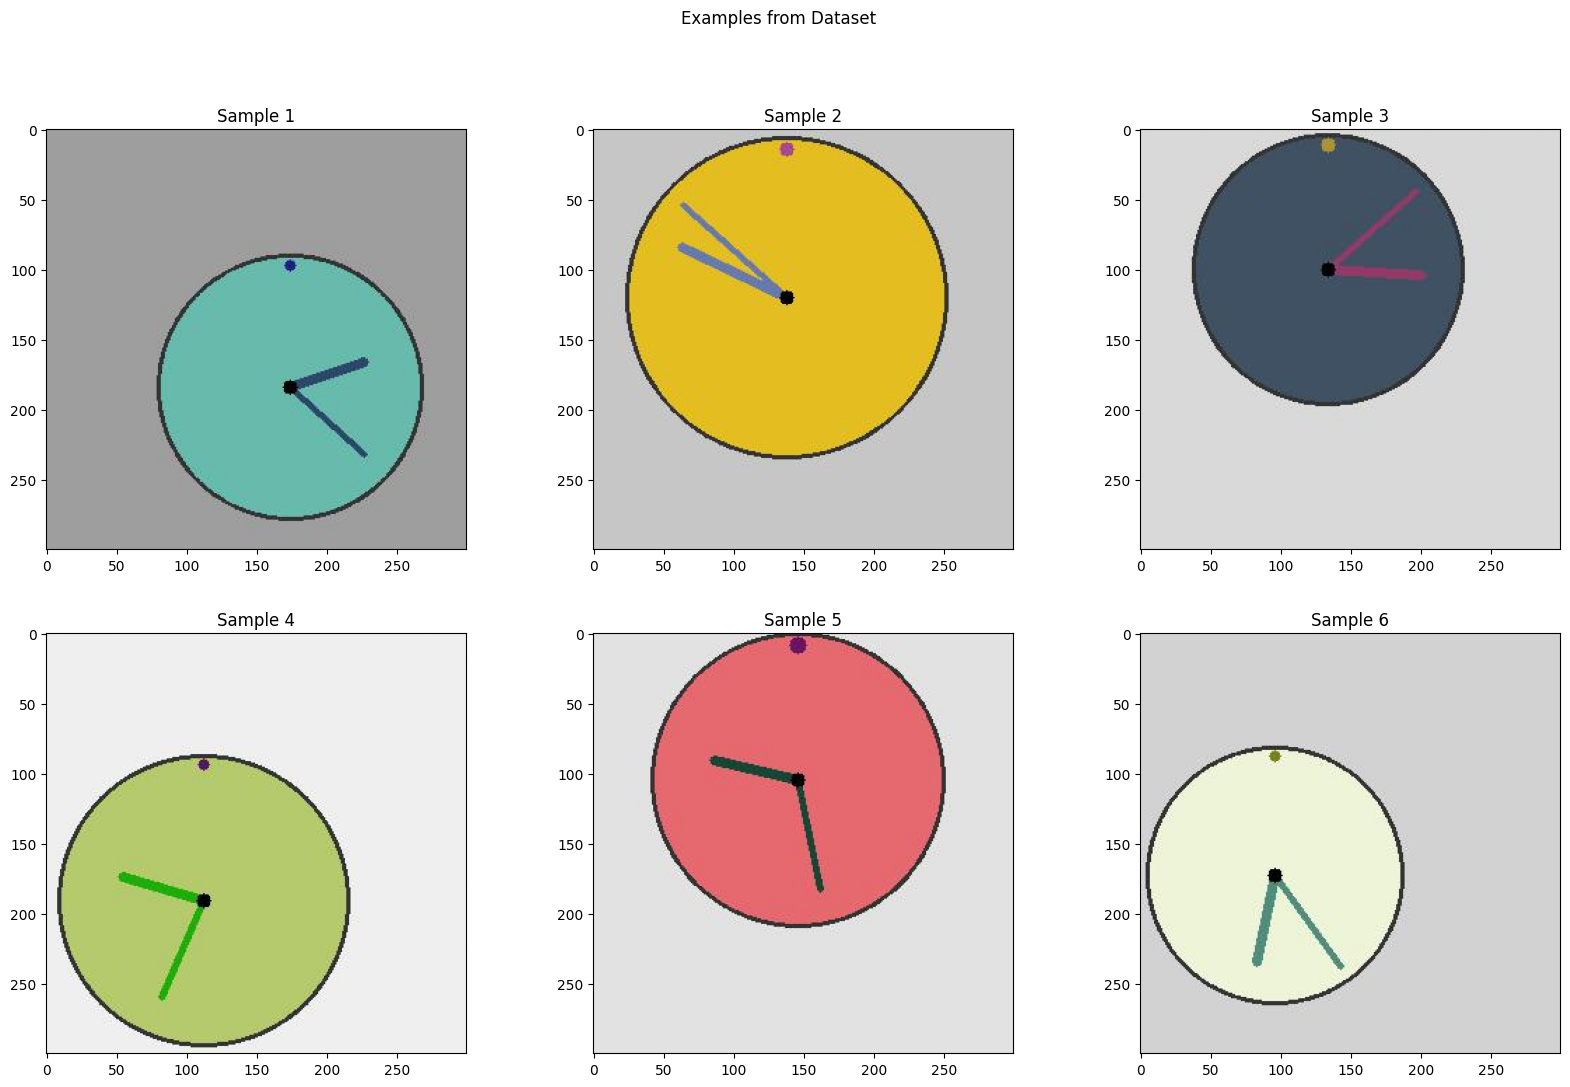

In [8]:
sample_dir = 'samples'
fig = plt.figure(figsize=(20, 12))
plt.suptitle('Examples from Dataset')
for i, file in enumerate(os.listdir(sample_dir)):
    img = image.load_img(os.path.join(sample_dir, file),
                         interpolation='box')
    img = image.img_to_array(img, dtype='float32')
    img /= 255.0
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title('Sample ' + str(i+1))

In [9]:
labels_df = pd.read_csv(labels_dir)
labels_df['tuples'] = [tuple(x) for x in labels_df.values]
labels_df['tuples'] = [('h' + str(x), 'm' + str(y)) for x,y in labels_df['tuples'].values]
labels_df = labels_df.drop(columns=['hour', 'minute'])
# labels_df = labels_df.reset_index()
binarizer = MultiLabelBinarizer()
y = binarizer.fit_transform(labels_df['tuples'])

In [10]:
labels_df.head()

,tuples
0,"(h4, m2)"
1,"(h9, m44)"
2,"(h3, m6)"
3,"(h3, m30)"
4,"(h2, m3)"


In [11]:
labels_df['tuples'].value_counts()

(h4, m4)      94
(h7, m22)     94
(h10, m48)    93
(h1, m24)     92
(h6, m32)     92
              ..
(h6, m27)     48
(h9, m7)      47
(h2, m30)     47
(h9, m48)     47
(h7, m35)     46
Name: tuples, Length: 720, dtype: int64

In [12]:
train, test = train_test_split(labels_df, 
                               stratify=labels_df['tuples'],
                               test_size=0.20,
                               random_state=42
                              )

train_idx, test_idx = list(train.index), list(test.index)

In [13]:
def generate(image_directory, labels, train_idx=None, batch_size=64, size=(224, 224)):
    
    """
    Function to create generator of images and labels for the neural network. This allows for training
    the model with the limited memory available. The images and labels are generated in batches of a given size.
    The images are loaded, added to a batch, preprocessed and have their features extracted using a prebuilt model
    (in this case Xception Model). 
    
    Parameters
    ----------
    image_directory: str
        The path where the images are located
    labels: array-like or list
        list of labels in multi-label binary format
    batch_size: int, default=64
        the number of images per batch
    size: tuple, default=(224, 224)
        the height and width to which the image is resized. 
    
    Yields
    ------
    image_batch: array
        Array of image features of size=batch_size
    labels_batch: array
        Array of labels in multi-label binary format of size=batch_size
    
    """
    
   
    prebuilt_model = xception.Xception(include_top=True,                      
              weights='imagenet')                                           
    
    xception_model = Model(inputs=prebuilt_model.input,        
                           outputs=prebuilt_model.layers[-2].output)       
    
    
    
    while 1:
        
        if train_idx==None:
            image_filenames = os.listdir(image_directory)                  
        else:
            image_filenames = [str(idx) + '.jpg' for idx in train_idx]
            
        random.shuffle(image_filenames)                                    

        
        image_batch = []                                                  
        labels_batch = []                                                 
        
        for file in image_filenames:                                        

            index = int(file.split('.')[0])                                
            
            img = image.load_img(os.path.join(image_directory, file),      
                                 target_size=size,
                                 interpolation='box')
            
            img_arr = image.img_to_array(img, dtype='float32')              
            
            label = labels[index]                                          
    
            image_batch.append(img_arr)                                    
            labels_batch.append(label)                                

    
            if len(image_batch)==batch_size:                               
                image_batch = np.array(image_batch)                       
                image_batch = xception.preprocess_input(image_batch)        
                image_features = xception_model.predict(image_batch)       
                image_batch = np.array(image_features)                       
                image_batch = image_batch.reshape(batch_size,              
                                                  image_features.shape[1])   
                labels_batch = np.array(labels_batch)                        
                yield image_batch, labels_batch                              
                image_batch = []                                             
                labels_batch = []                                            
                gc.collect()                     

In [14]:
BATCH_SIZE = 256
IMAGE_SIZE = (299, 299)
EPOCHS = 12
STEPS = int(len(train_idx) / BATCH_SIZE) + 20

In [15]:
sample_generator = next(generate(image_directory=image_dir, 
                                 labels=y,
                                 train_idx=train_idx,
                                 batch_size=1, 
                                 size=IMAGE_SIZE))

1/1 [==============================] - 1s 1s/step


In [16]:
sample_generator

(array([[0.        , 0.        , 0.        , ..., 0.16234978, 0.15398474,
         0.11270656]], dtype=float32),
 array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0]]))

In [17]:
INPUT_DIM = sample_generator[0][0].shape
OUTPUT_DIM = sample_generator[1].shape[1]

In [18]:
def create_model(input_shape, output_shape):
    
    """
    Function to build and compile neural network to predict analog clocks from images
    
    Parameters
    ----------
    input_shape: tuple
        Shape tuple not including the batch_size, example: (2048, )
    output_shape: int
        Number of nodes in final layer
    
    Returns
    -------
    model: Keras model object
        A compiled Keras model
    """

    input_layer = Input(shape=input_shape)
    norm  = BatchNormalization()(input_layer)
    drop = Dropout(0.25)(norm)
    fc1 = Dense(256, activation='relu')(norm)
    fc2 = Dense(256, activation='relu')(fc1)
    output1 = Dense(output_shape, activation='sigmoid')(fc2)
    
    #contructing model from layers
    model = Model(inputs=input_layer,
                  outputs=output1)
    
    #compiling model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']
                  )
    
    return model

In [19]:
model = create_model(input_shape=INPUT_DIM,
                     output_shape=OUTPUT_DIM)

In [20]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2048)]            0         
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 72)                18504     
                                                                 
Total params: 617,032
Trainable params: 612,936
Non-trainable params: 4,096
_________________________________________________

In [21]:
generator = generate(image_directory=image_dir,
                     labels=y,
                     train_idx=train_idx,
                     batch_size=BATCH_SIZE, 
                     size=IMAGE_SIZE)

In [22]:
history = model.fit(generator, 
                    epochs=EPOCHS, 
                    steps_per_epoch=STEPS)

176/176 [==============================] - 2487s 14s/step - loss: 0.0325 - accuracy: 0.8578
Epoch 8/12
176/176 [==============================] - 2518s 14s/step - loss: 0.0297 - accuracy: 0.8708
Epoch 9/12
176/176 [==============================] - 2534s 14s/step - loss: 0.0270 - accuracy: 0.8791
Epoch 10/12
176/176 [==============================] - 2509s 14s/step - loss: 0.0247 - accuracy: 0.8870
Epoch 11/12
176/176 [==============================] - 2505s 14s/step - loss: 0.0228 - accuracy: 0.8891
Epoch 12/12
8/8 [==============================] - 14s 2s/step


In [23]:
def predict(image_directory, indices=None, plot=False):
    
    """
    Function to predict all images in a given path
    
    Parameters
    ----------
    image_directory: str
        Path for images to be predicted
    indices: list, default = None
        Indices corresponding to image labels to predict
    plot: boolean, default=False
        Whether or not to create plot of predictions
        
    Returns
    -------
    predictions_list: list
        List of predictions corresponding to the images
    """
    
    images_list = []
    
    prebuilt_model = xception.Xception(include_top=True,
                                       weights='imagenet')         
    
    xception_model = Model(inputs=prebuilt_model.input,
                           outputs=prebuilt_model.layers[-2].output) 
    
    if indices!=None:
        image_filenames = [str(idx) + '.jpg' for idx in indices]
    else:
        image_filenames = os.listdir(image_directory)
    
    if plot:
        dim = int(np.ceil(np.sqrt(len(image_filenames))))
        fig, axs = plt.subplots(nrows=dim, 
                                ncols=dim,
                                figsize=(20, 14))
        plt.suptitle('Example of Model Predictions', fontsize=32)
        
#         axs = axs.flatten()
        
    
    
    for i, file in enumerate(image_filenames):
        

        img = image.load_img(os.path.join(image_directory,
                                          file))                   
        img_arr = image.img_to_array(img, dtype='float32')        
    
        if plot:
            axs.flat[i].imshow(img_arr/255.0)
            
        images_list.append(img_arr)
        gc.collect()       
    
    print('preprocessing...')
    images_list = np.array(images_list)
    img_arr = xception.preprocess_input(images_list)               
    print('extracting features...')
    img_features = xception_model.predict(img_arr)               
    img_features = np.array(img_features)
    print('predicting...')
    prediction = model.predict(img_features)                                      
    hour_max = np.argmax(prediction[:, :12], axis=1)               
    minute_max = np.argmax(prediction[:, 12:], axis=1) + 12          
    prediction_list = [(binarizer.classes_[x],                      
                        binarizer.classes_[y]) 
                        for (x,y) in list(zip(hour_max, minute_max))]

    if plot:                                                       
        for i, v in enumerate(prediction_list):
            axs.flat[i].set_title(str(v[0]) + ' ' + str(v[1]))
            axs.flat[i].axis('off')
        for j in range(i+1, dim**2):                                
              fig.delaxes(axs.flat[j])
            
    return prediction_list

preprocessing...
extracting features...


ValueError: in user code:

    File "c:\Users\leona\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2137, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\leona\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2123, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\leona\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2111, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\leona\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 2079, in predict_step
        return self(x, training=False)
    File "c:\Users\leona\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\leona\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "model_4" is incompatible with the layer: expected shape=(None, 299, 299, 3), found shape=(None, 300, 300, 3)


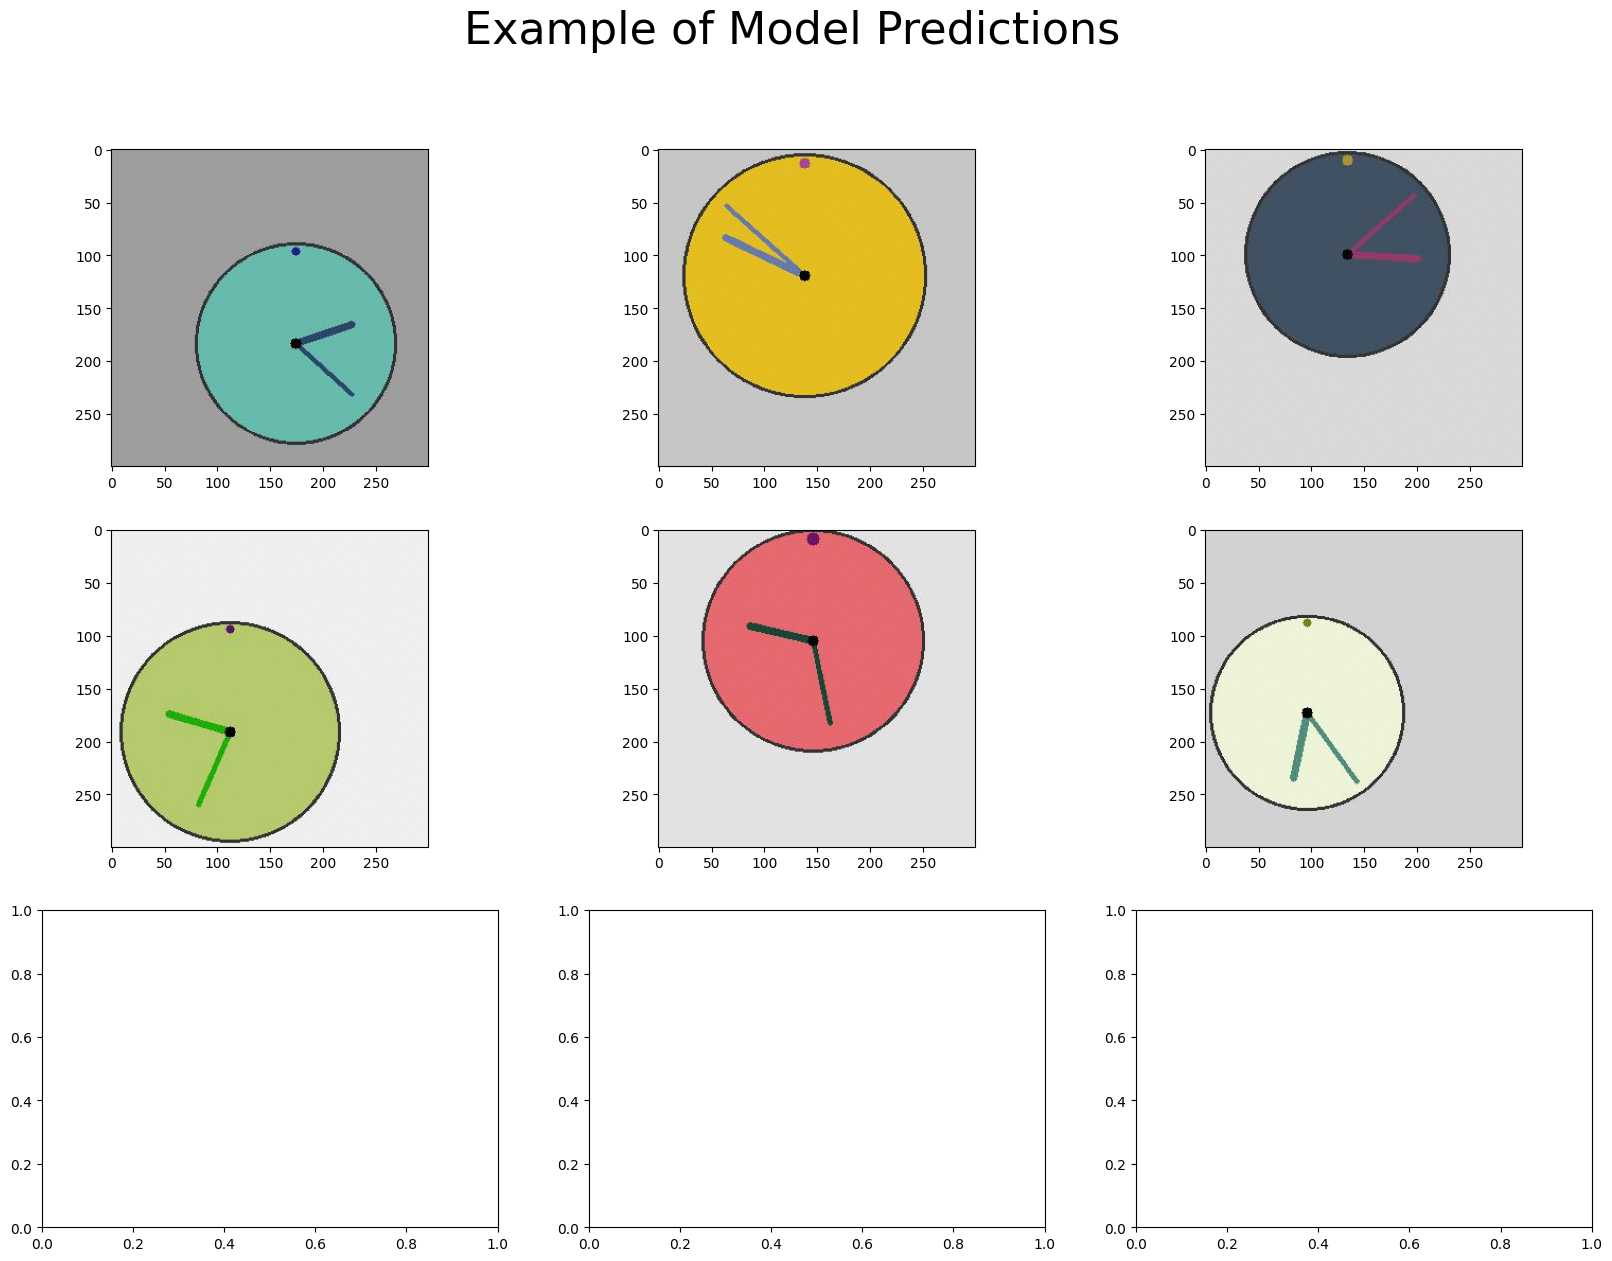

In [25]:
predictions = predict('samples',
                        plot=True)

In [26]:
SIZE = 64
sample_test = list(np.random.choice(test_idx, size=SIZE))

preprocessing...
extracting features...
2/2 [==============================] - 4s 2s/step
predicting...
2/2 [==============================] - 0s 2ms/step


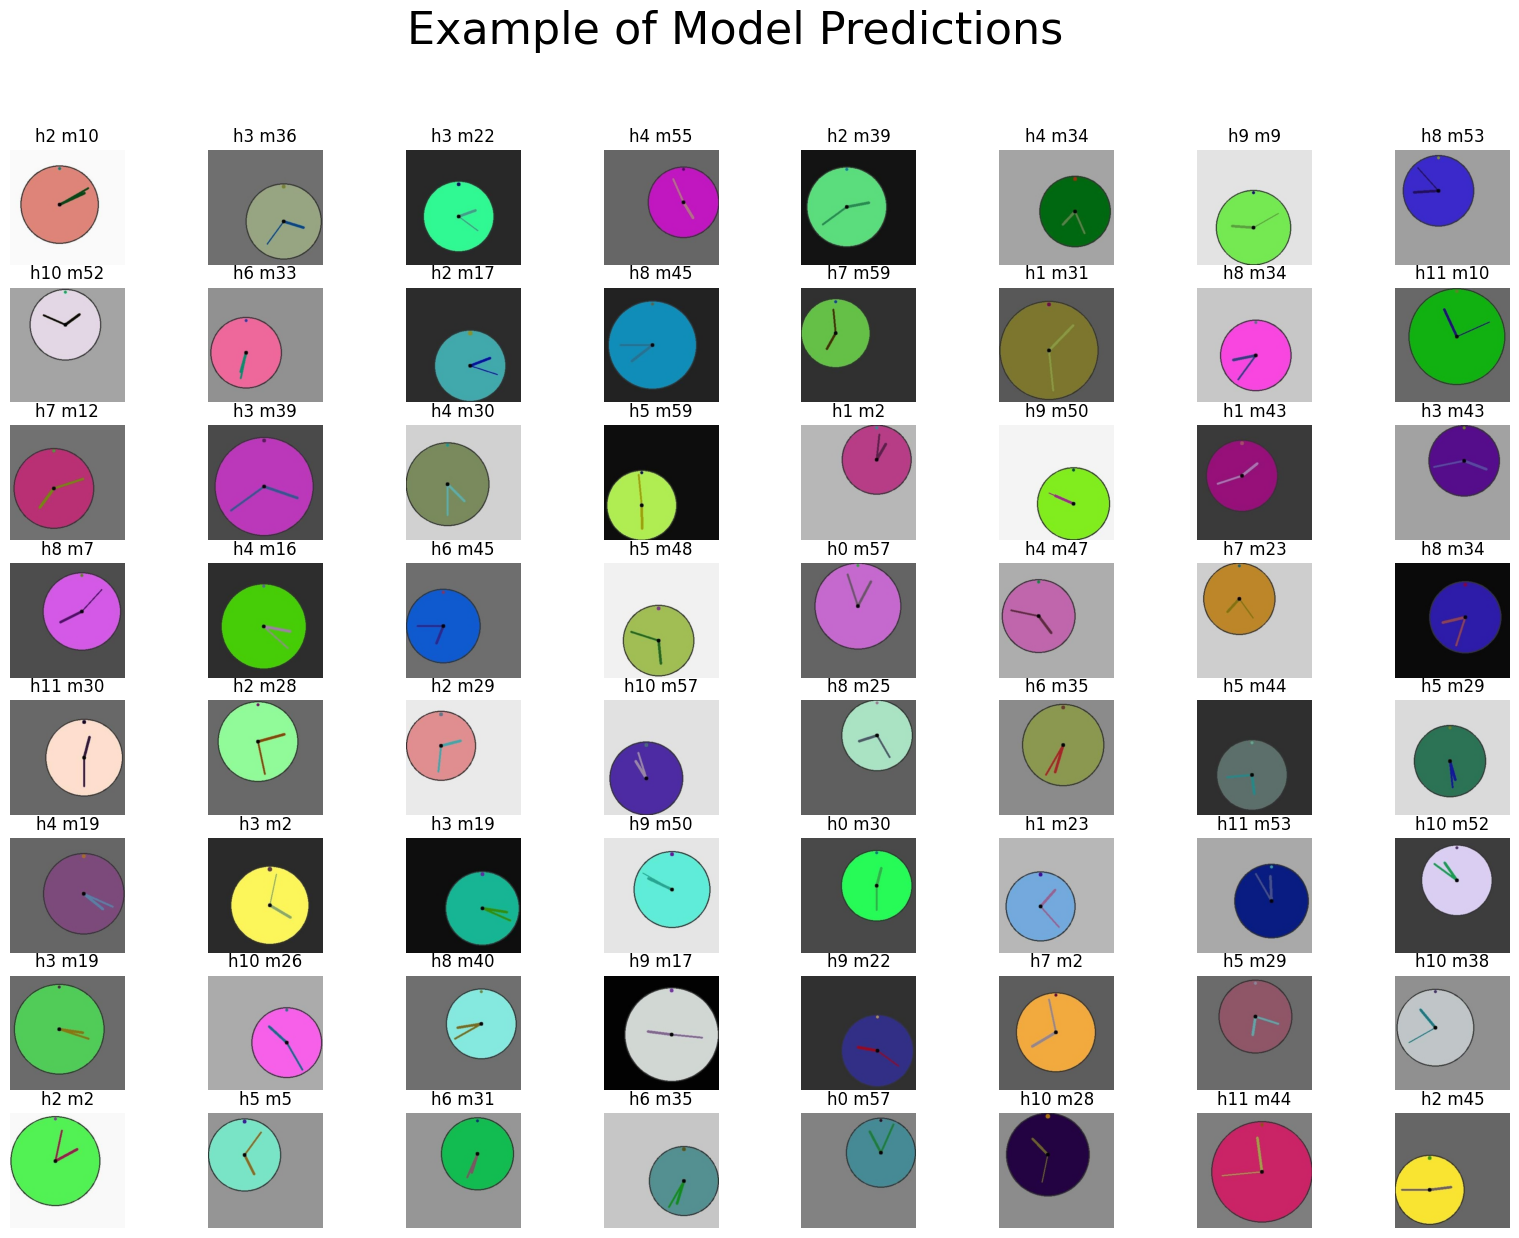

In [27]:
predictions = predict('images',
                        indices=sample_test,
                        plot=True)

In [28]:
sample_results = pd.DataFrame(list(zip(labels_df.loc[sample_test]['tuples'].values, pd.Series(predictions))), columns=['Actual', 'Predicted'])
sample_results

,Actual,Predicted
0,"(h2, m10)","(h2, m10)"
1,"(h3, m36)","(h3, m36)"
2,"(h2, m21)","(h3, m22)"
3,"(h4, m56)","(h4, m55)"
4,"(h2, m39)","(h2, m39)"
5,"(h7, m26)","(h4, m34)"
6,"(h9, m10)","(h9, m9)"
7,"(h8, m53)","(h8, m53)"
8,"(h1, m49)","(h10, m52)"
9,"(h6, m32)","(h6, m33)"


In [29]:
for layer in model.layers:
    layer.trainable = False
model.save('model')

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets
